In [1]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt
import SupplyNetPy.Components as scm

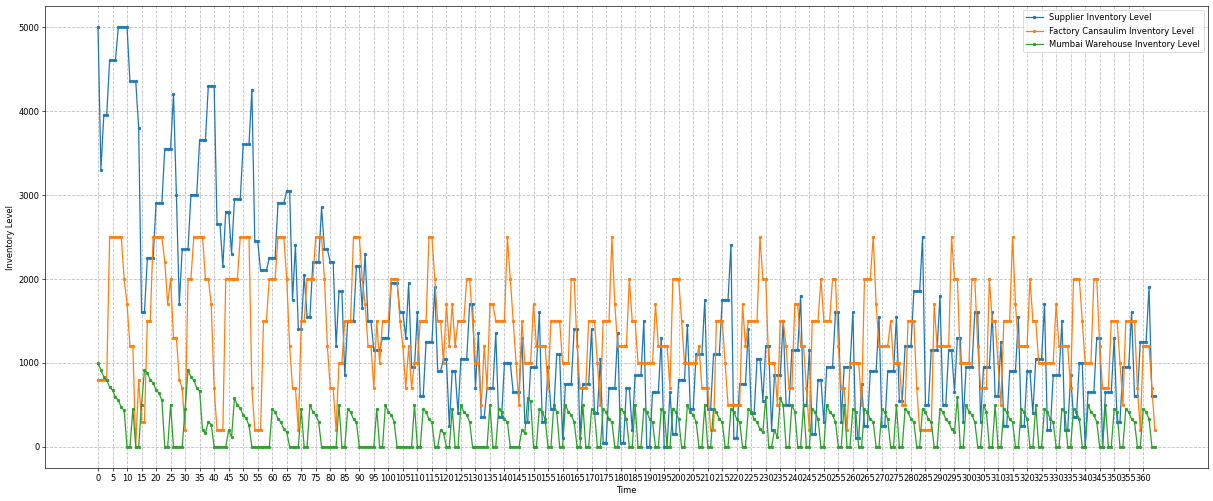

In [2]:
simtime = 365
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650,
                          extraction_time=3, mining_cost=0.01, cost=0.1)
#supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier", raw_material=raw_mat)
supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="supplier", raw_material=raw_mat, capacity=5000, 
                        initial_level=5000, inventory_holding_cost=0.1)
mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=10, manufacturing_time=1, sell_price=300, buy_price=150,
                             raw_materials=[(raw_mat,1)], batch_size=2500)
factory = scm.Manufacturer(env=env, ID='F1', name='Factory Cansaulim', capacity=2500, initial_level=800, shelf_life=10,
                           inventory_holding_cost=0.1, replenishment_policy=scm.SSReplenishment, policy_param={'s':1500, 'S':2500}, 
                           product=mouse, product_sell_price=300, inventory_type="perishable")
distributor = scm.InventoryNode(env=env, ID='D1', name='Mumbai Warehouse', node_type="warehouse", shelf_life=10,
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':500, 'Q':500}, 
                                product_buy_price=300, product_sell_price=320, inventory_type="perishable")
link1 = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 1)
link2 = scm.Link(env=env, ID='L2', source=factory, sink=distributor, cost=10, lead_time=lambda: 1)
demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand Pune', order_arrival_model=lambda: 2, order_quantity_model=lambda:50, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand Kalyan', order_arrival_model=lambda: 1, order_quantity_model=lambda:35, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)

scnet = scm.create_sc_net(env=env, nodes=[supplier, factory, distributor], links=[link1, link2], demands=[demand1, demand2])
scnet = scm.simulate_sc_net(scnet, sim_time=simtime, logging=False)
from matplotlib.pyplot import figure
figure(figsize=(25, 10), dpi=60)
for node in [supplier, factory, distributor]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0], inv_levels[:,1], label=f'{node.name} Inventory Level',marker='.')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
xticks = np.arange(0, simtime, 5)
plt.xticks(xticks)
plt.grid(which='both', linestyle='--', linewidth=1, alpha=0.8)
plt.legend()
plt.show()

In [3]:
print("*** *** Supplier, Factory and Distributor *** ***")
scm.print_node_wise_performance([supplier, factory, distributor])
print("\n*** *** Demand *** ***")
scm.print_node_wise_performance([demand1, demand2])

*** *** Supplier, Factory and Distributor *** ***
Performance Metric       Supplier                 Factory Cansaulim        Mumbai Warehouse         
backorder                [33, 39900]              [2, 1000]                [0, 0]                   
demand_fulfilled         [81, 82800]              [93, 46500]              [355, 14645]             
demand_placed            [0, 0]                   [81, 82800]              [93, 46500]              
demand_received          [82, 84600]              [93, 46500]              [355, 14645]             
fulfillment_received     [0, 0]                   [81, 82800]              [93, 46500]              
inventory_carry_cost     42510.0                  52900.0                  27890.499999999956       
inventory_level          600                      200                      500                      
inventory_spend_cost     0                        8280.0                   13950000                 
inventory_waste          0               